# Finetuning with Trainer and text-classification model validation

In [1]:
import os

if os.getenv("COLAB_RELEASE_TAG"):
   colab = True
else:
   colab = False

if colab:
    !pip install transformers[torch]
    !pip install accelerate -U
    !pip install datasets
    !pip install torchinfo
    #ImportError: Using the `Trainer` with `PyTorch` requires `accelerate>=0.20.1`: Please run `pip install transformers[torch]` or `pip install accelerate -U

In [2]:
from sklearn.model_selection import train_test_split
import datetime
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import pandas as pd
import pathlib
import seaborn as sn
import torch
import numbers

from tqdm.autonotebook import tqdm
from datasets import load_dataset, Dataset, DatasetDict
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from torchinfo import summary
from transformers import AutoModelForSequenceClassification, AutoConfig, Trainer, TrainingArguments, DataCollatorWithPadding, AutoTokenizer, pipeline
from transformers.modelcard import parse_log_history

C:\Users\Jakub\AppData\Local\Temp\ipykernel_23976\3430494536.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# Prepare parameters for each run of finetuning

In [3]:
# from huggingface_hub import notebook_login
# notebook_login()

# models = ['albert', 'bart', 'bert', 'big_bird', 'bigbird_pegasus', 'biogpt', 'bloom', 'camembert', 'canine', 'code_llama', 'convbert', 'ctrl', 'data2vec-text', 'deberta', 'deberta-v2', 'distilbert', 'electra', 'ernie', 'ernie_m', 'esm', 'falcon', 'flaubert', 'fnet', 'funnel', 'gemma', 'gpt-sw3', 'gpt2', 'gpt_bigcode', 'gpt_neo', 'gpt_neox', 'gptj', 'ibert', 'layoutlm', 'layoutlmv2', 'layoutlmv3', 'led', 'lilt', 'llama', 'longformer', 'luke', 'markuplm', 'mbart', 'mega', 'megatron-bert', 'mistral', 'mixtral', 'mobilebert', 'mpnet', 'mpt', 'mra', 'mt5', 'mvp', 'nezha', 'nystromformer', 'open-llama', 'openai-gpt', 'opt', 'perceiver', 'persimmon', 'phi', 'plbart', 'qdqbert', 'qwen2', 'reformer', 'rembert', 'roberta', 'roberta-prelayernorm', 'roc_bert', 'roformer', 'squeezebert', 'stablelm', 'starcoder2', 't5', 'tapas', 'transfo-xl', 'umt5', 'xlm', 'xlm-roberta', 'xlm-roberta-xl', 'xlnet', 'xmod', 'yoso',]
# =============================================
# tested = 'distilbert-base-cased', 'camembert-base', 'ctrl', 'xlnet-base-cased', 'roberta-base', 'distilroberta-base', 'flaubert/flaubert_base_cased'
# ----------
#too weak pc (cannot be loaded or runs at speeds <1 it/s) = 'albert-xlarge-v1', 't5-11B', 'LongformerForSequenceClassification', 'xlm-roberta-base', 'allenai/longformer-base-4096', 'facebook/bart-large',  flaubert/flaubert_large_cased (stopped at 0.5 epoch), 
# ----------
# need changes to run (check error logs) =  ProsusAI/finbert (despite adding padding proposed in error)
# =============================================
# model_path = 'SamLowe/roberta-base-go_emotions'
# model_path = 'distilbert-base-uncased'
# model_path = 'xlmoberta'

# , 'camembert-base', 'ctrl', 'xlnet-base-cased', 'roberta-base', 'distilroberta-base', 'flaubert/flaubert_base_cased'

# deprecated: transfo-xl-wt103

In [4]:
#if list of objects is provided list of all combinations of parameters will be created for running
params_tested = {'model': ['michellejieli/emotion_text_classifier'], # Pre-trained model names from the Hugging Face hub used for fine-tuning
                 'num_train_epochs': 30, # Number of times the model sees the entire training dataset.
                 'save_strategy': 'no', # Controls when to save model checkpoints ('epoch' or 'no').
                 'per_device_train_batch_size': 8, # Number of samples processed in each training step (personally, 8/16 work best, but 16 may find linear drop in inference speed during fine-tuning).
                 'per_device_eval_batch_size': 64, # Number of samples processed in each evaluation step. 
                 'split': [(80, 10, 10)], # Divides the dataset into training, testing, (and optionally) validation sets. Use 'balanced' for equal class representation in the validation set. Examples: (90,10) -> split into train and test proportionally; (80, 10, 10) splits into train,test, validate proportionally. 
                 'binary': False, # Indicates whether the task is binary (two classes) or multi-class classification.,
                 'balanced': True, # his way labels used for training are split evenly, fitting size to the lowest label count. In (80, 10, 'balanced') n (equal to 80% of least represented label) will be taken from each label, rest will be used for test.
                 }

# Controls whether to save logs during a process. When set to False, logging is disabled.
save_logs = True

def ratio_split_tuple(split):
    split_s = sum([i for i in split if isinstance(i, numbers.Integral)])
    new_split = tuple([i/split_s if isinstance(i, numbers.Integral) else i for i in split])
    return new_split

if isinstance(params_tested['split'], list):
    params_tested['split'] = list(map(ratio_split_tuple, params_tested['split']))
else:
    params_tested['split'] = ratio_split_tuple(params_tested['split'])

params_tested={i:[q] if type(q) is not list else q for (i,q) in params_tested.items()}
keys = list(params_tested.keys())
combinations = list(itertools.product(*params_tested.values()))
result = [{keys[i]: combination[i] for i in range(len(keys))} for combination in combinations]
print(*result, sep='\n')

train_params_looped = result

{'model': 'michellejieli/emotion_text_classifier', 'num_train_epochs': 30, 'save_strategy': 'no', 'per_device_train_batch_size': 8, 'per_device_eval_batch_size': 64, 'split': (0.8, 0.1, 0.1), 'binary': False, 'balanced': True}


## Functions

In [19]:
# Prepare functions

def csv_to_ds(path, binary, split, balanced=False):
    """
    Reads a CSV file, processes the data, and transforms it into a dataset ready for next steps.
    
    Args:
        path (str): The path to the CSV file.
        binary (bool): Flag indicating whether to convert labels to binary classification.
        split (float): See explanation and examples for params_tested dict
        balanced (bool): Flag indicating whether to balance training dataset or not.
    
    Returns:
        tuple: A tuple containing:
            * dataset: The processed dataset suitable for machine learning.
            * tg_map: A dictionary mapping target labels to numerical values.
            * reversed_tg_map: A dictionary mapping numerical values back to original labels. 
    """
    # csv to df
    new_df = pd.read_excel(path)
    new_df['label'] = new_df[['No_pathos', 'Positive', 'Negative']].idxmax(axis=1)
    new_df = new_df.rename(columns={'Sentence':'sentence'})
    if binary:
        new_df['label'] = new_df['label'].apply(lambda x: to_binary_classification(x))

    # target map and reversed target map
    tg_map = {k:i for i,k in enumerate(new_df['label'].unique())}
    reversed_tg_map = {v:k for k, v in tg_map.items()}
        
    ds = df_to_ds(new_df, split, tg_map, balanced=balanced)
    return ds, tg_map, reversed_tg_map

def to_binary_classification(x):
    return np.where(['Positive', 'Negative'].isin(x), 'Pathos', x)

def df_to_ds(df, split, tg_map, balanced=False):    
    df['label'] = df['label'].map(tg_map)
    if balanced:
        train_test = [pd.Series(name='sentence'), pd.Series(name='sentence'), pd.Series(name='label'), pd.Series(name='label')]
        n_for_training = df.groupby('label').count()['Source'].min()
        train_percentage = df.groupby('label').count()['Source'].apply(lambda x: (split[0]*n_for_training)/x).to_dict()

        for label_name, group in df.groupby('label'):
            print(label_name)
            train_test_group = train_test_split(group['sentence'], group['label'], test_size=1-train_percentage[label_name], random_state=42, shuffle=True)
            print(train_test_group[0].shape)
            print(train_test.shape)
            train_test = [pd.concat([i[0],i[1]], axis=0) for i in zip(train_test, train_test_group)]
    else:
        train_test = train_test_split(df['sentence'], df['label'], stratify=df['label'], test_size=split[1], random_state=42, shuffle=True)

    ds = DatasetDict()
    ds['train'] = Dataset.from_pandas(pd.concat([train_test[0], train_test[2]], axis=1))     
    if len(split)==2:
        ds['test'] = Dataset.from_pandas(pd.concat([train_test[1], train_test[3]], axis=1))
    elif len(split)==3:
        val_ratio = split[2]/(split[1]+split[2])
        test_validate = train_test_split(train_test[1], train_test[3], stratify=train_test[3], test_size=val_ratio, random_state=42, shuffle=True)
        ds['test'] = Dataset.from_pandas(pd.concat([test_validate[0], test_validate[2]], axis=1))
        ds['validate'] = Dataset.from_pandas(pd.concat([test_validate[1], test_validate[3]], axis=1))
        
    return ds

# Train functions

def compute_metrics(logits_and_labels):
  logits, labels = logits_and_labels
  predictions = np.argmax(logits, axis=-1)
  acc = np.mean(predictions == labels)
  f1 = f1_score(labels, predictions, average='macro')
  return {'accuracy': acc, 'f1': f1}

def save_logs_from_training_run(trainer, train_params, timestamp, trained_model_path, colab, target_map):
    log_history = parse_log_history(trainer.state.log_history)
    log_df = pd.DataFrame(log_history[1])
    log_df.insert(0, 'model', train_params['model'])
    log_df.insert(0, 'timestamp', timestamp)
    log_df['model_path'] = trained_model_path
    log_df['samples_per_s'] = log_history[0]['train_samples_per_second']
    log_df['steps_per_s'] = log_history[0]['train_steps_per_second']
    log_df['colab'] = colab
    log_df['per_device_train_batch_size'] = train_params['per_device_train_batch_size']
    log_df['per_device_eval_batch_size'] = train_params['per_device_eval_batch_size']
    log_df['split'] = str(train_params['split'])
    log_df['target_map'] = str(target_map)
    log_df['binary'] = train_params['binary']

    float_cols = log_df.select_dtypes(include='float64')
    log_df[float_cols.columns] = float_cols.apply(lambda x: round(x, 3))
    log_df.to_csv('output/training_logs.csv', mode='a', header= not os.path.isfile('output/training_logs.csv'), index=False)
    
def finetune(train_params, ds, target_map, save_logs):
    params_passed = {k: train_params[k] for k in train_params if k not in ['model', 'split', 'binary']}
    timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")
    trained_model_path = f'output/models/{train_params['model']}_{timestamp}'
    try:
        def tokenize_fn(batch):
            return tokenizer(batch['sentence'], truncation=True)
        
        #Tokenize dataset
        tokenizer = AutoTokenizer.from_pretrained(train_params['model'], trust_remote_code=True)
        # tokenizer.pad_token = tokenizer.eos_token
        if tokenizer.pad_token is None:
            tokenizer.add_special_tokens({'pad_token': '[PAD]'})
            # model.resize_token_embeddings(len(tokenizer))
        tokenized_datasets = ds.map(tokenize_fn, batched=True)

        # data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
        
        #Change labels
        config = AutoConfig.from_pretrained(train_params['model'], trust_remote_code=True)
        config.vocab_size = tokenizer.vocab_size
        config.id2label = reversed_target_map
        config.label2id = target_map
        
        #Load model
        model = AutoModelForSequenceClassification.from_pretrained(
            train_params['model'], config=config, ignore_mismatched_sizes=True, trust_remote_code=True)
        
        if tokenizer.pad_token is None:
            tokenizer.add_special_tokens({'pad_token': '[PAD]'})
            model.resize_token_embeddings(len(tokenizer))
    
        training_args = TrainingArguments(
          output_dir=f'{trained_model_path}/checkpoints',
          evaluation_strategy='epoch',
          logging_strategy='epoch',
          use_cpu = False,
          **params_passed
        )
    
        trainer = Trainer(
            model,
            training_args,
            train_dataset=tokenized_datasets["train"],
            eval_dataset=tokenized_datasets["test"],
            tokenizer=tokenizer,
            compute_metrics=compute_metrics,
            # data_collator=data_collator,
        )
        
        trainer.train()
        if save_logs:
            save_logs_from_training_run(trainer, train_params, timestamp, trained_model_path, colab, target_map)

    except Exception as e:
        print(f'Error: {e}')
        if save_logs:
            err_df = pd.DataFrame([[trained_model_path, str(e)]])
            err_df.to_csv('output/error_logs.csv', mode='a', header= not os.path.isfile('output/error_logs.csv'), index=False) 
    
# Validate functions

def get_log_for_val(checkpoint_path, sort_col='Step', logs_path='output/training_logs.csv'):
    training_logs = pd.read_csv(logs_path)
    if 'checkpoint-' in checkpoint_path:
        temp_path = checkpoint_path.rsplit('models/', 1)[-1]
        model_path, checkpoint_num = temp_path.rsplit('/checkpoints/checkpoint-')
        row = training_logs[(training_logs['model_path'].apply(lambda x: x.rsplit('models/', 1)[-1] == model_path)) & (training_logs['Step'] == int(checkpoint_num))]
    else:
        row = training_logs[training_logs['model_path'] == checkpoint_path].sort_values(sort_col, ascending=False).head(1)
    return row.iloc[0]

def validate(row, ds):
    val_sentences = ds['validate']['sentence']
    val_labels = [reversed_target_map[i] for i in ds['validate']['label']]

    classifier = pipeline('text-classification', model=os.path.join(row['model_path'], 'checkpoints', f"checkpoint-{row['Step']}"), device=0)
    predicted = [i['label'] for i in classifier(val_sentences)]
    return predicted, val_labels

def val_metrics(predicted, val_labels, target_map):
    print("acc:", accuracy_score(val_labels, predicted))
    print("f1:", f1_score(val_labels, predicted, average='macro'))

    cm = confusion_matrix(val_labels, predicted, normalize='true')
    plot_cm(cm, target_map)

def plot_cm(cm, target_map):
    classes = list(target_map.keys())
    df_cm = pd.DataFrame(cm, index=classes, columns=classes)
    ax = sn.heatmap(df_cm, annot=True, fmt='.2g')
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Target")


## Run

In [20]:
# Load PolarIs-Pathos to df
# source: https://github.com/kaatkaa/PolarIs-Corpora/blob/main/PolarIs-Full-Corpus/PolarIs-Full-Corpus-Pathos/PolarIs-Pathos.xlsx
if colab:
    from google.colab import drive
    drive.mount('/content/drive')
    data_path = 'drive/MyDrive/master_lm/PolarIs-Pathos.xlsx'
else:
    data_path = 'data/PolarIs-Pathos.xlsx'

#run looped 
for train_params in train_params_looped:
    dataset, target_map, reversed_target_map = csv_to_ds(data_path, train_params['binary'], train_params['split'], train_params['balanced'])
    # finetune(train_params, dataset, target_map, save_logs)

dataset

0
(676,)


AttributeError: 'list' object has no attribute 'shape'

## Validate

In [35]:
dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', '__index_level_0__'],
        num_rows: 14029
    })
    test: Dataset({
        features: ['sentence', 'label', '__index_level_0__'],
        num_rows: 779
    })
    validate: Dataset({
        features: ['sentence', 'label', '__index_level_0__'],
        num_rows: 780
    })
})

acc: 0.7282051282051282
f1: 0.5839240046047371
No_pathos: 567/532
Negative: 178/206
Positive: 35/42


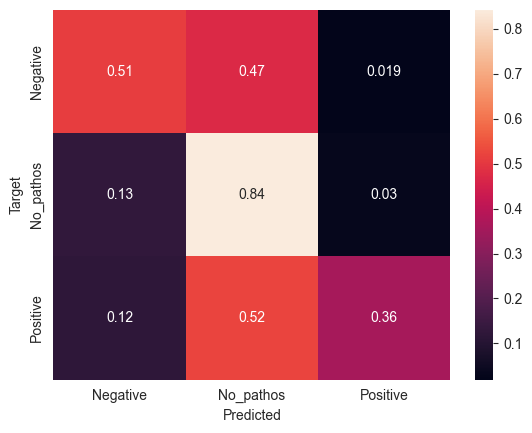

In [34]:
# Load PolarIs-Pathos to df
# source: https://github.com/kaatkaa/PolarIs-Corpora/blob/main/PolarIs-Full-Corpus/PolarIs-Full-Corpus-Pathos/PolarIs-Pathos.xlsx
if colab:
    from google.colab import drive
    drive.mount('/content/drive')
    data_path = 'drive/MyDrive/master_lm/PolarIs-Pathos.xlsx'
else:
    data_path = 'data/PolarIs-Pathos.xlsx'

df = pd.read_excel(data_path)
df['label'] = df[['No_pathos', 'Positive', 'Negative']].idxmax(axis=1)
df = df.rename(columns={'Sentence':'sentence'})

checkpoint_path = 'output/models/michellejieli/emotion_text_classifier_2024-04-11_09-02/checkpoints/checkpoint-15590'
# checkpoint_path = 'output/models/michellejieli/emotion_text_classifier_2024-04-11_09-02'    

val_row = get_log_for_val(checkpoint_path)
val_row['split'] = tuple([float(i) for i in val_row['split'][1:-1].split(', ')])

dataset, target_map, reversed_target_map = csv_to_ds(data_path, val_row['binary'], val_row['split'])
predicted_labels, true_labels = validate(val_row, dataset)
val_metrics(predicted_labels, true_labels, target_map)


print(f'No_pathos: {len([i for i in predicted_labels if i=='No_pathos'])}/{len([i for i in true_labels if i=='No_pathos'])}')
print(f'Negative: {len([i for i in predicted_labels if i=='Negative'])}/{len([i for i in true_labels if i=='Negative'])}')
print(f'Positive: {len([i for i in predicted_labels if i=='Positive'])}/{len([i for i in true_labels if i=='Positive'])}')

In [ ]:
print(f'No_pathos: {len([i for i in predicted if i=='No_pathos'])}/{len([i for i in true_labels if i=='No_pathos'])}')
print(f'Negative: {len([i for i in predicted if i=='Negative'])}/{len([i for i in true_labels if i=='Negative'])}')
print(f'Positive: {len([i for i in predicted if i=='Positive'])}/{len([i for i in true_labels if i=='Positive'])}')